### Exercise 1

Implement a `GradBoost` class with a `fit()` and `predict()` method for binary classification problems. The base learner of the `GradBoost` class is sklearn's `DecisionTreeRegressor`. The class should accept the squared and exponential loss as loss function. Implement line search to optimize $\alpha_t$ in each round $t$.


**(a)** Test your implementation using `DecisionTreeRegressor` as base learner on a dataset of your choice. Compare your results against sklearn's `GradientBoostingClassifier` with the following parameters

        loss='exponential', 
        criterion='squared_error',
        max_depth=1

Choose an appropriate learning rate and set the number of estimators as for `GradBoost`. 

**(b)** Plot the dot product $\langle \mathbf{r}_t, \mathbf{h}_t \rangle$, where $\mathbf{r}_t \in \mathbb{R}^n$ is the vector of residuals and $\mathbf{h}_t \in \mathbb{R}^n $ is the vector of predictions of the base learner $h_t$.

**(c)** Plot the empirical risk of the base learners $h_t$ as a function of the number $t$ of rounds. 

**(d)** Plot the empirical risk of the ensemble $f^{(t)}$ and the mean $\|\mathbf{r}_t\|_1/n$ of the absolute residuals as a function of the number $t$ of rounds. 

---
### Imports

In [1]:
import numpy as np
from sklearn.base import clone
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

---
### Derivative of Loss

In [2]:
class Loss:
    def eval(self):
        pass
    def derive(self):
        pass
    
class SquaredLoss(Loss):
    def eval(self, y_hat, y):
        return 0.5*(y_hat - y)**2
    
    def derive(self, y_hat, y):
        return y_hat - y
    
class ExponentialLoss(Loss):
    def eval(self, y_hat, y):
        return np.exp(-y*y_hat)
    
    def derive(self, y_hat, y):
        return -y*np.exp(-y*y_hat)

---
### Gradient Boosting

In [3]:
class Logger:
    def __init__(self):
        self.alignment = []     # dot product bwetween residuals and h_pred
        self.h_errors = []      # error rates of base learner
        self.f_errors = []      # error rates of ensemble
        self.r_mean = []        # sum of absolute residuals
     
    def __call__(self, y, y_hat, h_pred, residuals):
        u = np.dot(h_pred, residuals)
        y_hhat = 2*(h_pred >= 0) - 1
        y_fhat = 2*(y_hat >= 0) - 1
        
        self.alignment.append(u)
        self.h_errors.append(1.-accuracy_score(y, y_hhat))
        self.f_errors.append(1.-accuracy_score(y, y_fhat))
        self.r_mean.append(np.abs(residuals).mean())

        return u <= 0 or self.f_errors[-1] == 0

class GradBoost:
    def __init__(self, base_learner, n_estimators=10, loss=ExponentialLoss(), 
                 logger=None):
        self.T = n_estimators
        self.base_clf = base_learner
        self.estimators = None
        self.loss = loss
        self.logger = logger
    
    def fit(self, X, y):
        n_samples = X.shape[0]
        self.estimators = []

        # initial predictions of empty ensemble
        y_hat = np.zeros(n_samples)
        for _ in range(self.T):

            # compute residuals 
            r = -self.loss.derive(y_hat, y)

            # fit base learner
            h = clone(self.base_clf)  
            h.fit(X, r)
            
            # predictions of base learner
            h_pred = h.predict(X)

            # log results
            if self.logger:
                if self.logger(y, y_hat, h_pred, r): break

            # compute a using line search
            loss = lambda a : np.mean(self.loss.eval(y_hat + a*h_pred, y))
            result = minimize_scalar(loss)
            a = result.x

            # update ensemble predictions
            y_hat += a*h_pred 
            
            # update ensemble
            self.estimators.append((a, h))  

        return self.estimators

    
    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for a, h in self.estimators:
            pred += a * h.predict(X)
        return np.sign(pred)
    
    def score(self, X, y):
        y_hat = self.predict(X)  
        return accuracy_score(y, y_hat)

---
### Half-Moons Dataset

In [4]:
X, y = make_moons(n_samples=500, noise=0.25, random_state=10)
y[y==0] = -1 

---
### Test

In [5]:
def test(clf, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.5, 
                                                        random_state=10)
    clf.fit(X_train, y_train)

    train_error = 1. - clf.score(X_train, y_train)
    test_error = 1. - clf.score(X_test, y_test)

    print(f"train error = {100*train_error:.1f}%")
    print(f"test error  = {100*test_error:.1f}%")

---
### (a) 


**Sklearn's Gradient Boosting Classifier**

In [6]:
n_estimators = 200

print("Sklearn's GradBoost")
clf = GradientBoostingClassifier(loss='exponential', 
                                 criterion='squared_error',
                                 learning_rate=1., 
                                 max_depth=1, 
                                 n_estimators=n_estimators)
test(clf, X, y)


Sklearn's GradBoost
train error = 0.0%
test error  = 6.8%


**Gradient Boosting Implementation**

In [7]:
print("My GradBoost")
clf = GradBoost(DecisionTreeRegressor(max_depth=1), 
                n_estimators=n_estimators, 
                logger=Logger())
test(clf, X, y)


My GradBoost
train error = 0.0%
test error  = 7.6%


---
### (b)

**Dot product $\langle r, h_t\rangle$**

In [8]:
alignment = clf.logger.alignment
t = range(1, len(alignment)+1)

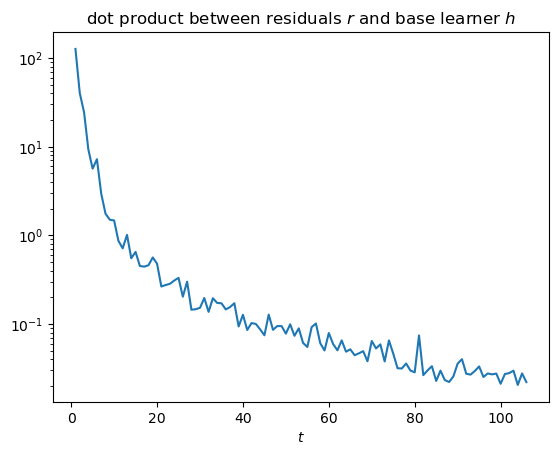

In [9]:
plt.semilogy(t, alignment)
plt.xlabel('$t$')
plt.title(r'dot product between residuals $r$ and base learner $h$')
plt.show()

---
### (c)

**Empirical risk of base learners**

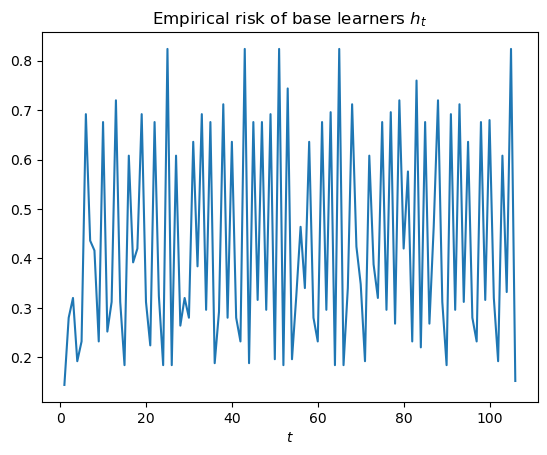

In [10]:
plt.plot(t, clf.logger.h_errors)
plt.xlabel('$t$')
plt.title('Empirical risk of base learners $h_t$')
plt.show()

---
### (d)

**Empirical risk of ensemble vs. absolute sum of residuals**

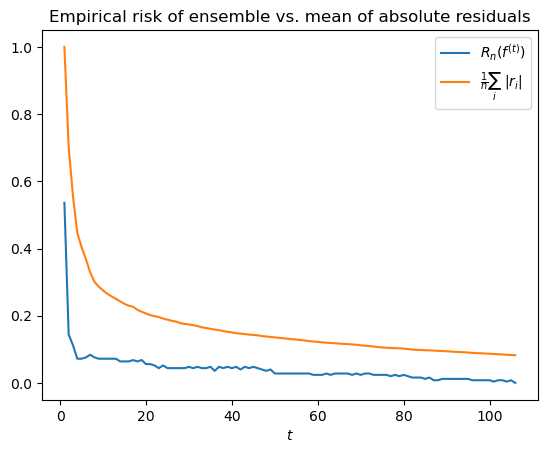

In [12]:
plt.plot(t, clf.logger.f_errors, label = r'$R_n\left(f^{(t)}\right)$')
plt.plot(t, clf.logger.r_mean, label = r'$\frac{1}{n}\sum_i \;|r_i|$')
plt.xlabel('$t$')
plt.title("Empirical risk of ensemble vs. mean of absolute residuals")
plt.legend()
plt.show()